In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.stats import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *
from simpsom.plots import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [2]:
def compute_anomalies_ds(ds: xr.Dataset, clim_type: str, normalized: bool = False) -> xr.Dataset:
    ds, coord = assign_clim_coord(ds, clim_type)
    clim = flox.xarray.xarray_reduce(
        ds,
        coord,
        func="mean",
        method="cohorts",
        expected_groups=np.unique(coord.values),
    )
    clim = smooth(clim, {clim_type: ("win", 61)})
    this_gb = ds.groupby(coord)
    if not normalized:
        return (this_gb - clim).reset_coords(clim_type, drop=True)
    variab = flox.xarray.xarray_reduce(
        ds,
        coord,
        func="std",
        method="cohorts",
        expected_groups=np.unique(coord.values),
    )
    variab = smooth(variab, {clim_type: ("win", 61)})
    return ((this_gb - clim).groupby(coord) / variab).reset_coords(clim_type, drop=True)

In [3]:
exp = MultiVarExperiment(
    "ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 30, 20, 80, [150, 200, 250, 300, 350]
)
ds = exp.ds
all_jets, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
all_props_over_time = exp.props_over_time()
props_as_ds["nao"] = get_nao(interp_like=props_as_ds)
time_mask = (props_as_ds.time.dt.season=="JJA")
summer_jets = np.unique(flags[time_mask.values])[:-1]
ds_late = flatten_by(ds.sel(time=time_mask), "s")
subset = ["mean_lon", "mean_lat", "mean_lev", "width", "persistence", "int"]
props_as_np = props_as_ds[subset].sel(time=time_mask).to_dataarray().values
props_as_np = props_as_np.transpose(1, 0, 2).reshape(props_as_np.shape[1], props_as_np.shape[0] * props_as_np.shape[2]) 

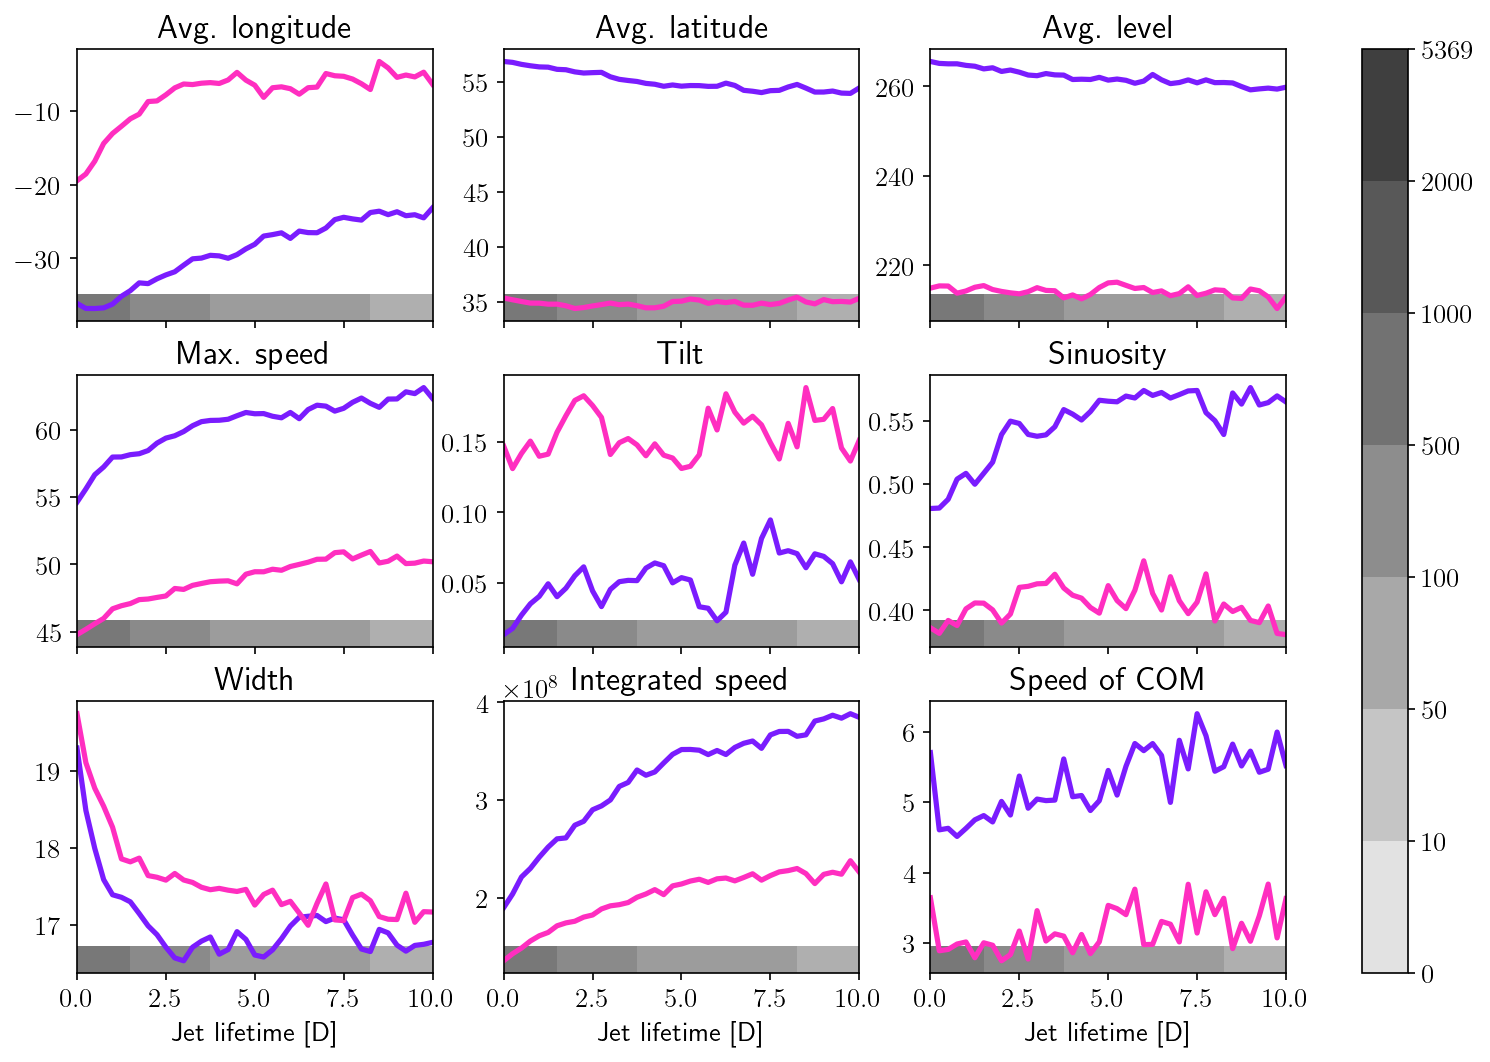

In [ ]:
subset = ["mean_lon", "mean_lat", "mean_lev", "Spe", "tilt", "sinuosity", "width", "int", "com_speed"]
fig, axes = plt.subplots(3, 3, figsize=(13, 8), dpi=150, tight_layout=False, sharex="all")
axes = np.atleast_2d(axes).ravel() # makes sense I promise
this_apot = all_props_over_time.sel(jet=summer_jets)
# long_lasting = this_apot["persistence"][:, 0].values > 2
# this_apot = this_apot.sel(jet=long_lasting)
alive_jets = (~this_apot["mean_lat"].isnull()).sum("jet").values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 10, 50, 100, 500, 1000, 2000, alive_jets.max()], cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes)
xlim = 0, 40
this_apot = this_apot.isel(point=np.arange(xlim[0], xlim[1] + 1))
x = this_apot.point.values / 4
alive_jets = alive_jets[:xlim[1] + 1]

for ax, varname in zip(axes, subset):
    y1 = this_apot[varname].where(this_apot["is_polar"]).mean("jet").values
    y2 = this_apot[varname].where(~this_apot["is_polar"].astype(bool)).mean("jet").values
    ax.plot(x, y1, color=COLORS[1], lw=2.5)
    ax.plot(x, y2, color=COLORS[2], lw=2.5)
    ax.set_title(PRETTIER_VARNAME[varname])
    ylim = np.asarray(ax.get_ylim())
    if varname == "mean_lev":
        ax.invert_yaxis()
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x, ybounds, alive_jets[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_ylim(ylim)
    if varname in subset[-3:]:
        ax.set_xlabel("Jet lifetime [D]")

fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/jet_props_misc/tracked_props.png", **SAVE_KWARGS)

In [35]:
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1959, 2022), "JJA", -30, 40, 30, 75, "all", 'hourofyear', {'hourofyear': ('win', 60)}, None,
)
da_T = exp_T.da
da_cee = exp_T.select_heat_wave_cluster(10, 6)
JA_mask = np.isin(da_cee.time.dt.month, [7, 8])
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(da_cee, q=0.95, fill_holes=True, output_type="both")
props_as_ds_anoms_masked = mask_from_t(da_cee, props_as_ds_anoms, q=0.95, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

In [1]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]

fig, axes = plt.subplots(
    max(1, len(data_vars) // 3),
    min(3, len(data_vars)),
    figsize=(min(12, 4 * len(data_vars)), max(1, len(data_vars) // 3) * 2.6),
    constrained_layout=True,
    sharex="all",
    sharey="all"
)
axes = np.atleast_2d(axes)
months = np.unique(props_as_ds_anoms.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
time_around_beg = time_around_beg.values
dt = (props_as_ds_anoms.time.values[1] - props_as_ds_anoms.time.values[0]).astype("timedelta64[h]")
colors = COLORS[2:0:-1]
n_hotspell = 1
x = props_as_ds_anoms_masked.time_around_beg.values.astype("timedelta64[h]")
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_anoms_masked.jet.values):
        this_da = props_as_ds_anoms_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim="heat_wave").values
        ax.plot(x, [0] * len(x), color="black", alpha=0.8, lw=1)
        ax.plot(x, mean, color=colors[j], lw=3, ls="solid")
                
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim="heat_wave").values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), 19 * 24
ticklabels = x.astype("timedelta64[D]").astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]", fontsize=14)
    ylim = -2, 2
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xticks(ticks, ticklabels, ha="center")
    ax.set_xlim(xlim)
    ax.vlines(0, *ylim, color="black", lw=1, ls="solid", zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel("Number of heat waves still alive")
for ax in axes[-1, :]:
    ax.set_xlabel("Time around heat wave [D]")
plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_vs_hotspell_anoms.png", dpi=300)

NameError: name 'plt' is not defined